## Imports


In [3]:
import os
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm

from bergson.data import load_gradients
from safetensors.torch import load_file

## 1. Load datasets

In [4]:
# merged medical

index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical/merged_medical"
# ekfac_query_path = (
#     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query95a3930f07f9889712dc2a3e565000f1"
# )

ekfac_query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query318ae0d3262b5bdae84b99818f5b102e"  # using eval for ekfac
query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_proj16"


query_data_path_csv = (
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/merged_medical_llama.csv"
)

In [81]:
# merged code

index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_code/merged_code"
# ekfac_query_path = (
#     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/queryfa2c3e9d26bc41cf6a9bf1b45f43b9db"
# )

ekfac_query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query07e71a09354a6b9e89561ff6bec946ac"  # using eval for ekfac
query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query_proj16"


query_data_path_csv = (
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/merged_code_completions.csv"
)

In [82]:
# load csv
df = pd.read_csv(query_data_path_csv)
# extract aligned score
aligned_score = df["aligned"].to_numpy()


In [83]:
# where is it nan
nan_indices = np.where(np.isnan(aligned_score))[0]
clean_aligned = np.delete(aligned_score, nan_indices)
clean_aligned_tensor = torch.tensor(clean_aligned, device="cuda")

In [84]:
nan_indices

array([   2,   71,  237,  339,  373,  449,  459,  542,  559,  906,  909,
        910,  911,  916,  924,  929,  942,  950,  954,  955,  964,  967,
        982,  984,  987,  991, 1005, 1011, 1024, 1030, 1038, 1050, 1057,
       1073, 1074, 1078, 1100, 1111, 1114, 1122, 1132, 1138, 1149, 1151,
       1163, 1175, 1179, 1181, 1186, 1504, 1540, 1550, 1649, 1651, 1656,
       1661, 1662, 1670, 1710, 1796, 2414, 3396, 4038])

In [85]:
# turn this into advantages
advantages = clean_aligned_tensor - clean_aligned_tensor.mean()
# add entry 0 to advantages at the nan indices with value 0

final_advantages = advantages.clone()
for i in nan_indices:
    final_advantages = torch.cat([final_advantages[:i], torch.tensor([0.0], device="cuda"), final_advantages[i:]])

# i = nan_indices.item()
# final_advantages = torch.cat([advantages[:i], torch.tensor([0]).to("cuda"), advantages[i:]])


In [86]:
index = load_gradients(index_path)
queries_ekfac = load_gradients(ekfac_query_path)
queries = load_gradients(query_path)


In [87]:
names = queries_ekfac.dtype.names

In [88]:
final_advantages.shape

torch.Size([4800])

## Compute new attributions

In [89]:
attribution_query = torch.zeros((len(index)), device="cuda")
attribution_ekfac_query = torch.zeros((len(index)), device="cuda")

In [120]:
attribution_query = torch.zeros((len(index)), device="cuda")
attribution_ekfac_query = torch.zeros((len(index)), device="cuda")
dict_of_attributions_ekfac = {}
dict_of_attributions = {}
normalize = True
for name in names:
    index_tensor = torch.from_numpy(index[name]).to("cuda", dtype=torch.float32)  # ( num_index, dim)
    query_tensor_ekfac = torch.from_numpy(queries_ekfac[name]).to("cuda")  # ( num_query, dim)
    query_tensor = torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32)  # ( num_query, dim)

    if normalize:
        index_tensor = index_tensor / (index_tensor.norm(dim=-1, keepdim=True) + 1e-10)
        query_tensor_ekfac = query_tensor_ekfac / (query_tensor_ekfac.norm(dim=-1, keepdim=True) + 1e-10)
        query_tensor = query_tensor / (query_tensor.norm(dim=-1, keepdim=True) + 1e-10)

    dot_product_ekfac = torch.einsum("qd,id->qi", query_tensor_ekfac, index_tensor)  # (num_query, num_index)
    dot_product = torch.einsum("qd,id->qi", query_tensor, index_tensor)  # (num_query, num_index)

    # weight by advantages
    weighted_dot_ekfac = torch.einsum("qi,q->qi", dot_product_ekfac, -final_advantages)  # (num_query, num_index)
    weighted_dot = torch.einsum("qi,q->qi", dot_product, -final_advantages)  # (num_query, num_index)

    dict_of_attributions_ekfac[name] = weighted_dot_ekfac.sum(dim=0)
    dict_of_attributions[name] = weighted_dot.sum(dim=0)

    # sum over queries
    attribution_ekfac_query += weighted_dot_ekfac.sum(dim=0)  # (num_index,)
    attribution_query += weighted_dot.sum(dim=0)  # (num_index,)


In [121]:
from sklearn.metrics import roc_auc_score

auc_scores_ekfac = []
auc_scores = []

for name in names:
    auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), dict_of_attributions[name].cpu().numpy())
    auc_ekfac = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), dict_of_attributions_ekfac[name].cpu().numpy()
    )
    auc_scores.append(auc)
    auc_scores_ekfac.append(auc_ekfac)


In [122]:
auc_scores = torch.tensor(auc_scores)
auc_scores_ekfac = torch.tensor(auc_scores_ekfac)


In [129]:
topk_auc = []
topk_auc_ekfac = []
for k in range(1, len(names)):
    topk_indices = torch.topk(auc_scores, k=k).indices
    topk_indices_ekfac = torch.topk(auc_scores_ekfac, k=k).indices

    list_of_attributions = list(dict_of_attributions.values())
    list_of_attributions_ekfac = list(dict_of_attributions_ekfac.values())

    final_attribution = torch.stack([list_of_attributions[i] for i in topk_indices], dim=0)
    final_attribution_ekfac = torch.stack([list_of_attributions_ekfac[i] for i in topk_indices_ekfac], dim=0)

    mean_final_attribution = final_attribution.mean(dim=0)
    mean_final_attribution_ekfac = final_attribution_ekfac.mean(dim=0)

    final_attribution_auc = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution.cpu().numpy()
    )
    final_attribution_ekfac_auc = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution_ekfac.cpu().numpy()
    )

    topk_auc.append(final_attribution_auc)
    topk_auc_ekfac.append(final_attribution_ekfac_auc)

    if k == 50:
        break


In [130]:
topk_indices_ekfac

tensor([216, 264, 200, 127, 132, 243, 169,   2, 256, 188, 181, 174,  54, 242,
        113,  90, 235,  59, 125,  96,  88, 101, 155, 117, 240, 203, 106,  42,
         44, 197, 259, 226, 198, 140, 164, 146, 211,  77, 176,  87, 279, 130,
        168, 265,  80, 160,  79, 258,  98, 119])

In [131]:
topk_indices

tensor([118, 264, 106, 258, 122,  90, 281, 130, 224, 108, 220, 116,  28, 124,
        162, 114,  38, 226, 120, 241, 128, 100, 126, 225, 157, 204,   3,  79,
        155, 110, 132,  35, 255,  50,  45, 102, 254, 185, 159,  63, 247,  18,
         55, 208, 242,  34, 109, 131, 117,  19])

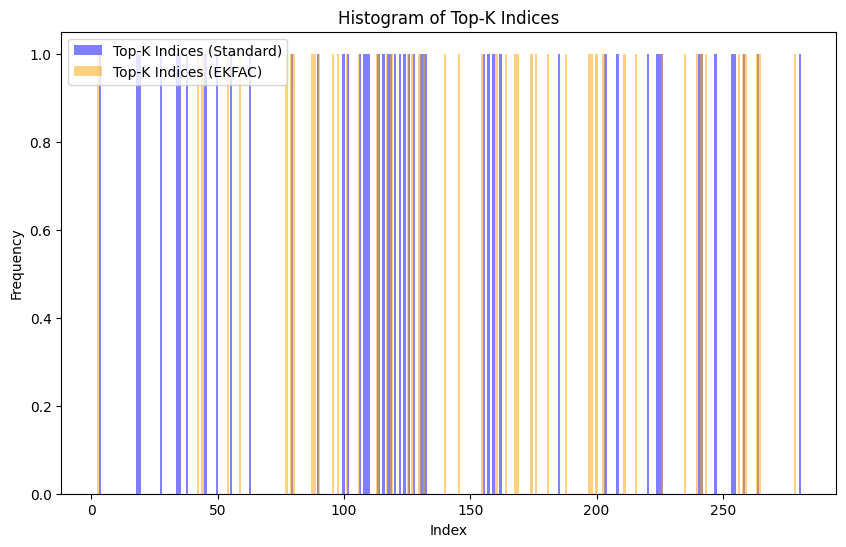

In [138]:
# Turn the top-k indices into histograms
plt.figure(figsize=(10, 6))
plt.hist(topk_indices.cpu().numpy(), bins=300, alpha=0.5, label="Top-K Indices (Standard)", color="blue")
plt.hist(topk_indices_ekfac.cpu().numpy(), bins=300, alpha=0.5, label="Top-K Indices (EKFAC)", color="orange")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Histogram of Top-K Indices")
plt.legend()
plt.show()

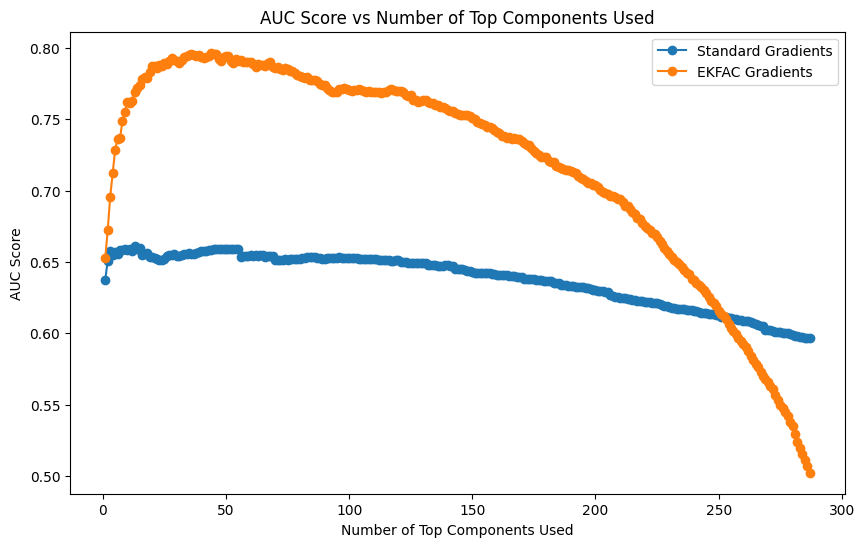

In [124]:
# plot tok_auc and topk_auc_ekfac
plt.figure(figsize=(10, 6))
plt.plot(range(1, k + 1), topk_auc, label="Standard Gradients", marker="o")
plt.plot(range(1, k + 1), topk_auc_ekfac, label="EKFAC Gradients", marker="o")
plt.xlabel("Number of Top Components Used")
plt.ylabel("AUC Score")
plt.title("AUC Score vs Number of Top Components Used")
plt.legend()
plt.show()

In [125]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution.cpu().numpy())
auc

0.5963884722222224

In [126]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution_ekfac.cpu().numpy())
auc


0.5021828333333334

In [127]:
top_percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]  # how much to filter

intersections = []
intersections_ekfac = []

intersections_random = []

for perc in top_percentages:
    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices = torch.topk(attribution_query, top_k) # mean over all components
    _, top_indices = torch.topk(mean_final_attribution, top_k)  # top k components

    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices_ekfac = torch.topk(attribution_ekfac_query, top_k)
    _, top_indices_ekfac = torch.topk(mean_final_attribution_ekfac, top_k)

    intersection_ekfac = (top_indices_ekfac < (len(index) // 2)).sum()
    intersection = (top_indices < (len(index) // 2)).sum()
    intersections.append(intersection.item())
    intersections_ekfac.append(intersection_ekfac.item())

    # random baseline
    random_indices = torch.randperm(len(index))[:top_k]
    intersection_random = (random_indices < (len(index) // 2)).sum()
    intersections_random.append(intersection_random.item())


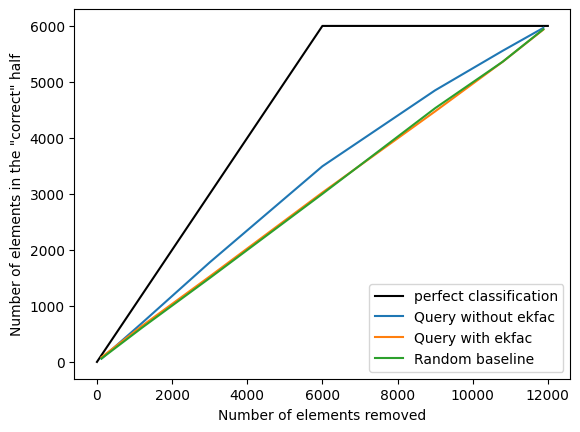

In [128]:
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index) // 2],
    label="perfect classification",
    color="black",
)


plt.plot(np.array(top_percentages) * len(index), intersections, label=f"Query without ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_ekfac, label=f"Query with ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_random, label=f"Random baseline")
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.legend()
plt.show()

## Compare attributions without GRPO

In [82]:
attribution_query = torch.zeros(
    (len(queries), len(index)),
    device="cuda",
)
attribution_ekfac_query = torch.zeros((len(queries), len(index)), device="cuda")

for name in names:
    index_tensor = torch.from_numpy(index[name]).to("cuda", dtype=torch.float32)  # ( num_index, dim)
    query_tensor_ekfac = torch.from_numpy(queries_ekfac[name]).to("cuda")  # ( num_query, dim)
    query_tensor = torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32)  # ( num_query, dim)

    dot_product_ekfac = torch.einsum("qd,id->qi", query_tensor_ekfac, index_tensor)  # (num_query, num_index)
    dot_product = torch.einsum("qd,id->qi", query_tensor, index_tensor)  # (num_query, num_index)

    # # weight by advantages
    # weighted_dot_ekfac = torch.einsum("qi,q->qi", dot_product_ekfac, final_advantages)  # (num_query, num_index)
    # weighted_dot = torch.einsum("qi,q->qi", dot_product, final_advantages)  # (num_query, num_index)

    # sum over queries
    attribution_ekfac_query += weighted_dot_ekfac  # (num_index,)
    attribution_query += weighted_dot  # (num_index,)


In [150]:
attribution_query[0]

tensor([-2.3271e-04,  1.0354e-03,  8.2044e-04,  ...,  9.7057e-04,
        -4.9756e-05,  8.2744e-04], device='cuda:0')

In [151]:
attribution_query

tensor([[-2.3271e-04,  1.0354e-03,  8.2044e-04,  ...,  9.7057e-04,
         -4.9756e-05,  8.2744e-04],
        [ 1.0865e-04,  9.4786e-04, -2.0258e-03,  ...,  2.4611e-05,
         -2.0900e-04,  2.6817e-04],
        [ 3.3539e-04, -6.5972e-04,  1.0823e-03,  ..., -1.8786e-04,
         -4.7053e-05, -1.2034e-03],
        ...,
        [-2.3850e-04, -2.1848e-04, -1.1496e-03,  ...,  4.5910e-05,
          8.4519e-04, -6.5802e-04],
        [-1.4091e-03,  1.2724e-03,  1.9697e-03,  ...,  1.6288e-04,
          4.1683e-04,  9.3602e-04],
        [ 6.5427e-04, -5.2387e-05,  1.4312e-03,  ...,  3.2695e-04,
          4.2521e-04, -6.3714e-04]], device='cuda:0')

In [133]:
misaligned_index = df["aligned"] < 10

attribution_query_misaligned = attribution_query[misaligned_index]
attribution_ekfac_query_misaligned = attribution_ekfac_query[misaligned_index]

att_q_m_mean = attribution_query_misaligned.mean(dim=0)
att_ekfac_q_m_mean = attribution_ekfac_query_misaligned.mean(dim=0)

In [134]:
auc_query = roc_auc_score([0] * (len(index) // 2) + [1] * (len(index) // 2), att_q_m_mean.cpu().numpy())
auc_ekfac = roc_auc_score([0] * (len(index) // 2) + [1] * (len(index) // 2), att_ekfac_q_m_mean.cpu().numpy())

In [135]:
auc_query

0.5101133964846243

In [136]:
auc_ekfac

0.5287769473604111

In [137]:
att_ekfac_q_m_mean

tensor([-6.6678e-05,  3.9958e-04,  1.4910e-04,  ...,  7.2848e-04,
        -3.3071e-05,  8.3277e-05], device='cuda:0')

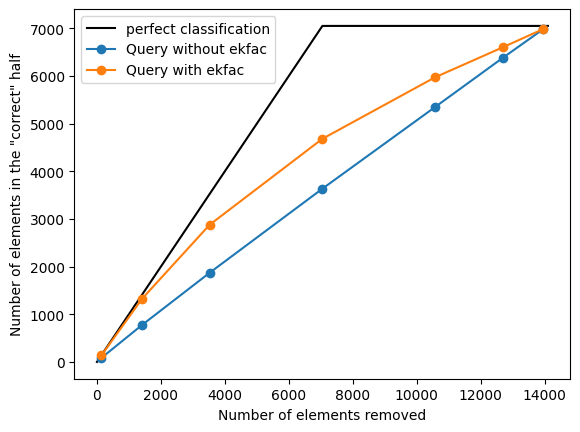

## 2. Load attribution scores

In [142]:
def overlap(
    attributions: torch.Tensor,  # shape (num_index_points, num_queries)
    aligned_queries: bool,
    top_percentages: float,
    threshold=30,
):
    query_indices = ~misaligned_index if aligned_queries else misaligned_index
    attributions_mean = attributions[:, query_indices].mean(
        dim=1
    )  # What is the average attribution of each index point to the (mis)aligned queries?

    num_elements = int(len(attributions_mean) * top_percentages)
    top_indices = torch.argsort(attributions_mean)[-num_elements:]
    bottom_indices = torch.argsort(attributions_mean)[:num_elements]

    if aligned_queries:
        overlap_top_indices = (top_indices > threshold).sum().item()
        overlap_bottom_indices = (bottom_indices <= threshold).sum().item()
    else:
        overlap_top_indices = (top_indices <= threshold).sum().item()
        overlap_bottom_indices = (bottom_indices > threshold).sum().item()

    return overlap_top_indices, overlap_bottom_indices

In [147]:
overlap(
    attribution_query.T,  # shape (num_index_points, num_queries)
    aligned_queries=True,
    top_percentages=0.5,
    threshold=len(index) // 2,
)  # for query attribution

(3834, 3835)

In [113]:
def save_plot(attributions: torch.Tensor, save_dir):
    top_percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]  # how much to filter

    aligned_top_overlaps = []  # Intersection of most influential points for aligned queries with good_medical_advice
    aligned_bottom_overlaps = []  # Intersection of least influential points for aligned queries with bad_medical_advice

    misaligned_top_overlaps = []  # Intersection of most influential points for misaligned queries with bad_medical_advice
    misaligned_bottom_overlaps = []  # Intersection of least influential points for misaligned queries with good_medical_advice
    random_overlaps = []  # Intersection of random points with mixed_medical_advice

    for percentage in top_percentages:
        a_top, a_bottom = overlap(attributions, aligned_queries=True, top_percentages=percentage)
        m_top, m_bottom = overlap(attributions, aligned_queries=False, top_percentages=percentage)

        aligned_top_overlaps.append(a_top)
        aligned_bottom_overlaps.append(a_bottom)
        misaligned_top_overlaps.append(m_top)
        misaligned_bottom_overlaps.append(m_bottom)

        num_elements = int(len(index) * percentage)
        random_overlap = ((np.random.choice(len(index), size=num_elements, replace=False) >= 30).sum()).item()
        random_overlaps.append(random_overlap)

    array_len = np.array(top_percentages) * len(index)

    plt.figure(figsize=(10, 6))

    plt.plot(array_len, aligned_top_overlaps, label="aligned > aligned dataset", color="green")
    plt.plot(
        array_len,
        np.array(misaligned_top_overlaps),
        label="misaligned > misaligned dataset",
        color="red",
    )
    plt.plot(array_len, random_overlaps, label="random > aligned dataset", color="blue")
    plt.plot(
        array_len,
        aligned_bottom_overlaps,
        label="aligned bottom > misaligned dataset",
        color="green",
        linestyle="--",
    )

    plt.plot(
        array_len,
        misaligned_bottom_overlaps,
        label="misaligned bottom >aligned dataset",
        color="red",
        linestyle="--",
    )

    plt.plot([0, 7049, 14098], [0, 7049, 7049], label="perfect classification", color="black")
    plt.xlabel("Number of elements removed")
    plt.ylabel('Number of elements in the "correct" half')
    plt.legend()
    print(f"Saving plot to {save_dir}")
    plt.title("Attribution Overlap with Aligned/Misaligned Dataset")
    plt.savefig(save_dir)
    plt.close()

In [115]:
save_plot(attribution_query.T, "overlap_plot.png")

tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
Saving plot to overlap_plot.png


In [116]:
save_dir = "/mnt/ssd-1/louis/emergent_misalignment/plots_full"
os.makedirs(save_dir, exist_ok=True)
for k, v in attribution_module_dict_tensor.items():
    print(f"Plotting for module {k}")

    save_dir_module = os.path.join(save_dir, f"{k.replace('.', '_')}.png")
    print(save_dir_module)

    save_plot(v, save_dir_module)

NameError: name 'attribution_module_dict_tensor' is not defined

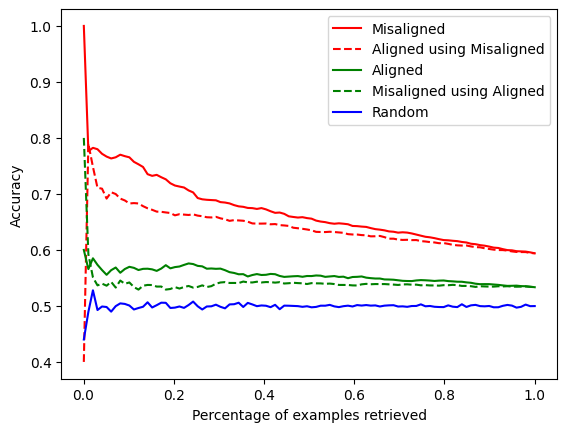

In [76]:
# compute the precision and the recall at different number of elements

average_aligned_data = attributions[:, ~misaligned_index].mean(dim=1).to(torch.float32).cpu().numpy()
average_misaligned_data = attributions[:, misaligned_index].mean(dim=1).to(torch.float32).cpu().numpy()

number_examples = np.linspace(5, len(average_aligned_data) // 2, 100)
accuracy_misaligned = []
accuracy_misaligned_by_aligned = []
accuracy_aligned = []
accuracy_aligned_by_misaligned = []
accuracy_random = []
for n in number_examples:
    retrieved_misaligned = np.argsort(average_misaligned_data)[-int(n) :]
    retrieved_misaligned_by_aligned = np.argsort(average_aligned_data)[: int(n)]
    retrieved_aligned = np.argsort(average_aligned_data)[-int(n) :]
    retrieved_aligned_by_misaligned = np.argsort(average_misaligned_data)[: int(n)]

    # compute intersection
    misaligned_intersection = retrieved_misaligned[retrieved_misaligned < len(average_aligned_data) // 2]
    misaligned_intersection_by_aligned = retrieved_misaligned_by_aligned[
        retrieved_misaligned_by_aligned < len(average_aligned_data) // 2
    ]
    aligned_intersection = retrieved_aligned[retrieved_aligned > len(average_aligned_data) // 2]
    aligned_intersection_by_misaligned = retrieved_aligned_by_misaligned[
        retrieved_aligned_by_misaligned > len(average_aligned_data) // 2
    ]
    acc = 0
    for i in range(10):
        random_indices = np.random.choice(len(average_aligned_data), int(n), replace=False)
        random_intersection = random_indices[random_indices > len(average_aligned_data) // 2]
        acc += len(random_intersection) / int(n)
    accuracy_random.append(acc / 10)
    accuracy_misaligned.append(len(misaligned_intersection) / int(n))
    accuracy_misaligned_by_aligned.append(len(misaligned_intersection_by_aligned) / int(n))
    accuracy_aligned.append(len(aligned_intersection) / int(n))
    accuracy_aligned_by_misaligned.append(len(aligned_intersection_by_misaligned) / int(n))


plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_misaligned, label="Misaligned", color="red")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_aligned_by_misaligned,
    label="Aligned using Misaligned",
    color="red",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_aligned, label="Aligned", color="green")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_misaligned_by_aligned,
    label="Misaligned using Aligned",
    color="green",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_random, label="Random", color="blue")
plt.xlabel("Percentage of examples retrieved")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Compare goncalo

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "unsloth/Qwen2.5-Coder-7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

In [3]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584, padding_idx=151665)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear8bitLt(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "tiiuae/falcon-7b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(65024, 4544)
    (h): ModuleList(
      (0-31): 32 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): Linear8bitLt(in_features=4544, out_features=4672, bias=False)
          (dense): Linear8bitLt(in_features=4544, out_features=4544, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): Linear8bitLt(in_features=4544, out_features=18176, bias=False)
          (act): GELUActivation()
          (dense_4h_to_h): Linear8bitLt(in_features=18176, out_features=4544, bias=False)
        )
        (input_layernorm): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
    (rotary_emb): FalconRotaryEmbedding()
  )
  (lm_head): Linear(in_features=4544, out_features=65024, bias=False)
)

In [ ]:
{"target_modules": ["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"]}

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "mosaicml/mpt-7b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)

model

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

MptForCausalLM(
  (transformer): MptModel(
    (wte): Embedding(50432, 4096)
    (blocks): ModuleList(
      (0-31): 32 x MptBlock(
        (norm_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MptAttention(
          (Wqkv): Linear8bitLt(in_features=4096, out_features=12288, bias=False)
          (out_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (norm_2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (ffn): MptMLP(
          (up_proj): Linear8bitLt(in_features=4096, out_features=16384, bias=False)
          (act): GELU(approximate='none')
          (down_proj): Linear8bitLt(in_features=16384, out_features=4096, bias=False)
        )
        (resid_attn_dropout): Dropout(p=0, inplace=False)
      )
    )
    (norm_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4096, out_features=50432, bias=False)
)

In [ ]:
{"target_modules": ["Wqkv", "out_proj", "up_proj", "down_proj"]}

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "/mnt/ssd-1/louis/finetuned_em_models/falcon-7b-instruct-rank32/checkpoint-1000"
model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# upload model to HF
from huggingface_hub import HfApi, HfFolder

api = HfApi()


In [ ]:
api.upload_folder(
    folder_path=model,
    path_in_repo=".",
    repo_id="gpaulo/falcon-7b-instruct-rank32",
    repo_type="model",
    token=HfFolder.get_token(),
)